<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# ARIMA Code-Along

_Authors: Joseph Nelson (DC)_

---

> **Note:** This code-along lesson is intended to come after the slideshow presentation and be guided in detail by the instructor.

### Learning Objectives
- Practice using Statsmodels' time series tools on bus ridership data.
- Plot the decomposition of the time series.
- Conduct a Dickey-Fuller test for stationarity and plot the results.
- Perform first and second order differencing, as well as seasonal differencing on data.
- Plot ACF and PACF with European retail data.
- Examine the use of SARIMAX state-space modeling for advanced time series forecasting.

### Lesson Guide
- [Statsmodels' Time Series Tools](#statsmodels-timeseries-tools)
- [Bus Ridership Data](#bus-ridership-data)
	- [Clean the Data](#clean-the-data)
	- [Create a Date Index for the Data](#create-a-date-index-for-the-data)
- [Plot the Riders Across Months](#plot-the-riders-across-months)
- [Decompose the Time Series and Plot](#decompose-the-timeseries-and-plot)
- [Dickey-Fuller Test of Stationarity](#dickey-fuller-test-of-stationarity)
	- [Perform a Test on the First-Differenced Time Series](#perform-test-on-the-first-differenced-timeseries)
	- [Perform a Test on *Seasonal*-Differenced Time Series](#perform-test-on-seasonal-differenced-timeseries)
	- [Perform a Test on the First Seasonal-Differenced Time Series](#perform-a-test-on-the-first-seasonal-differenced-timeseries)
- [Load the European Retail Data](#load-the-european-retail-data)
- [Create Autocorrelation and Partial Autocorrelation Plots](#create-autocorrelation-and-partial-autocorrelation-plots)
	- [Take a Second-Order Difference of the Retail Time Series](#take-a-second-order-difference-of-the-retail-timeseries)
- [Seasonal ARIMA With Additional Predictors (SARIMAX)](#seasonal-arima-with-additional-predictors-sarimax)
	- [Forecast Using the SARIMAX Model](#forecast-using-the-sarimax-model)
- [Additional Resources](#additional-resources)

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns

<a id="statsmodels-timeseries-tools"></a>
## Statsmodels' Time Series Tools
---

Statsmodels (the dev version), offers a wide variety of reliable time series analysis tools. We will start off by loading the autocorrelation and partial autocorrelation functions, as well as a function for decomposing time series.

In [2]:
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

<a id="bus-ridership-data"></a>
## Bus Ridership Data
---

We are going to play around with some Portland, Oregon, bus data. Load in the bus data below and check it out.

<a id="clean-the-data"></a>
### Clean the Data

In [3]:
# Data: https://datamarket.com/data/set/22w6/portland-oregon-average-monthly-bus-ridership-100-january-1973-through-june-1982-n114#!ds=22w6&display=line
bus = pd.read_csv('../datasets/portland-oregon-average-monthly-.csv', index_col=0)
bus.index.name=None
bus.reset_index(inplace=True)
bus.head()

,index,"Portland Oregon average monthly bus ridership (/100) January 1973 through June 1982, n=114"
0,1960-01,648
1,1960-02,646
2,1960-03,639
3,1960-04,654
4,1960-05,630


In [4]:
bus.tail()

,index,"Portland Oregon average monthly bus ridership (/100) January 1973 through June 1982, n=114"
111,1969-04,1432
112,1969-05,1394
113,1969-06,1327
114,NaN,NaN
115,Portland Oregon average monthly bus ridership ...,n=114


There are a couple of bad rows. Get rid of them.

In [5]:
bus.drop(bus.index[115], inplace=True)
bus.drop(bus.index[114], inplace=True)

Make the `riders` column an integer.

In [6]:
# Riders:
bus.columns= ['index','riders']
# df['riders'] = df.riders.apply(lambda x: int(x)*100)
bus['riders'] = bus.riders.apply(lambda x: int(x))
bus.riders.head()

0    648
1    646
2    639
3    654
4    630
Name: riders, dtype: int64

<a id="create-a-date-index-for-the-data"></a>
### Create a Date Index for the Data

We are going to create an artificial date index using the `relativedelta()` function, as exemplified below. We will simply start at `1973-01-01` and iterate up a month at a time.

In [8]:
start = datetime.datetime.strptime("1973-01-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,114)] # edited to 115
bus['index'] =date_list
bus.set_index(['index'], inplace=True)
bus.index.name=None

print(len(date_list))  # Check
print(len(bus.index))   # Check

114
114


In [9]:
bus.head()

,riders
1973-01-01,648
1973-02-01,646
1973-03-01,639
1973-04-01,654
1973-05-01,630


<a id="plot-the-riders-across-months"></a>
## Plot the Riders Across Months
---

We can look at the raw ridership data first.

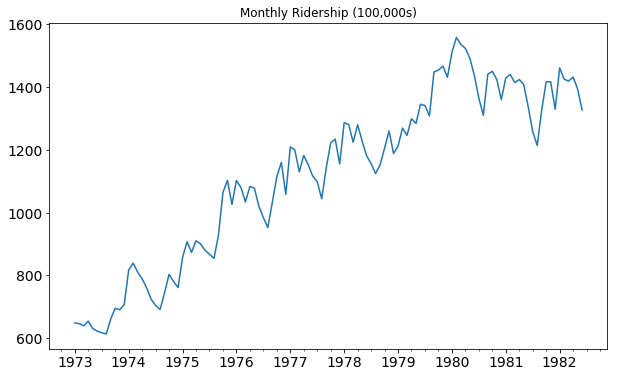

In [10]:
bus.riders.plot(figsize=(10,6), 
                title= 'Monthly Ridership (100,000s)', 
                fontsize=14)

<a id="decompose-the-timeseries-and-plot"></a>
## Decompose the Time Series and Plot
---

Using the `seasonal_decompose()` function, we can break the time series into its constituent parts.

Use the function on the `riders` data with a frequency of 12, then plot the data.

> **Hint:** The decomposition object from `seasonal_decompose()` has a `.plot()` function, like with Pandas DataFrames.

In [11]:
bus.dtypes

riders    int64
dtype: object

<Figure size 432x288 with 0 Axes>

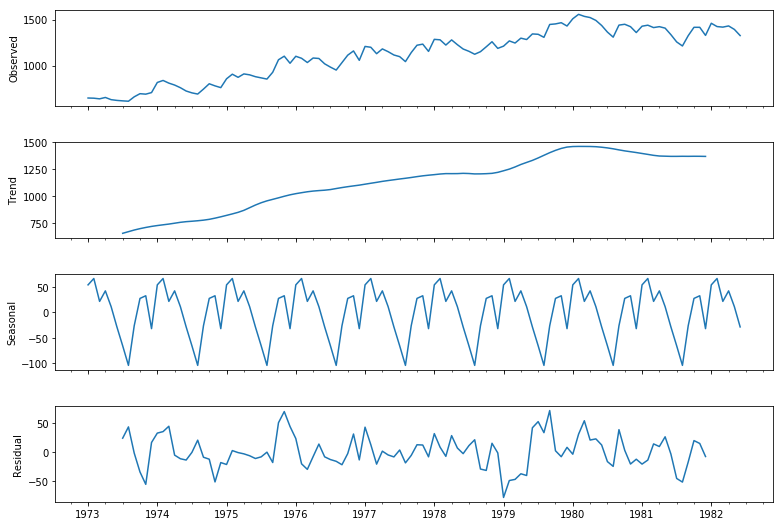

In [12]:
decomposition = seasonal_decompose(bus.riders, freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(12, 8)

**Plot just the seasonal component.**

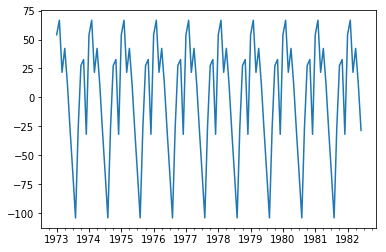

In [13]:
# Grab just one graphic doing the following:
seasonal = decomposition.seasonal 
seasonal.plot()

<a id="dickey-fuller-test-of-stationarity"></a>
## Dickey-Fuller Test of Stationarity
---

[We can perform an (augmented) Dickey-Fuller test of stationarity](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) to evaluate whether or not the time series is stationary.


In [15]:
# Define a Dickey-Fuller test.
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    # Determining rolling statistics:
    rolmean = timeseries.rolling(window=12, center=False).mean()
    rolstd = timeseries.rolling(window=12, center=False).std()

    # Plotting rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    # Performing a Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput) 


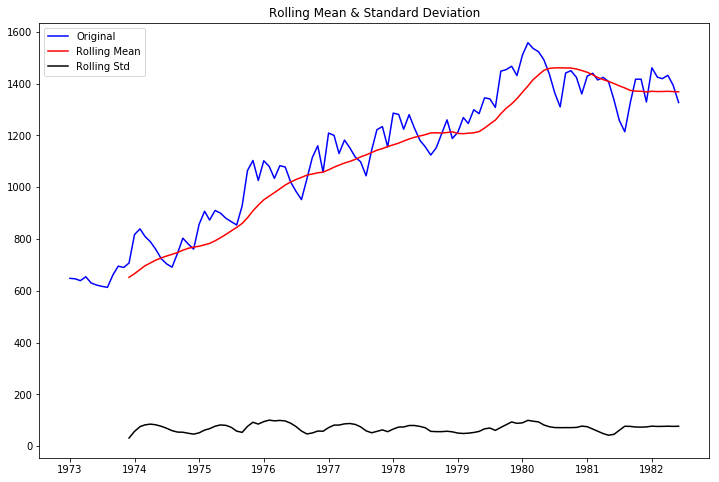

Results of Dickey-Fuller Test:
Test Statistic                  -1.536597
p-value                          0.515336
#Lags Used                      12.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [16]:
# Perform the test.
test_stationarity(bus.riders)

<a id="perform-test-on-the-first-differenced-timeseries"></a>
### Perform a Test on the First-Differenced Time Series

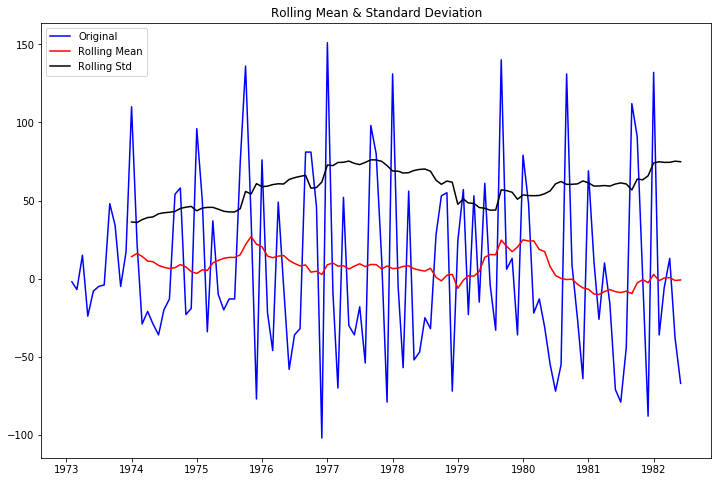

Results of Dickey-Fuller Test:
Test Statistic                  -1.938696
p-value                          0.314082
#Lags Used                      11.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [17]:
# First difference:
#bus['first_difference'].diff(1)
bus['first_difference'] = bus.riders - bus.riders.shift(1)  
test_stationarity(bus.first_difference.dropna(inplace=False))

<a id="perform-test-on-seasonal-differenced-timeseries"></a>
### Perform a Test on *Seasonal*-Differenced Time Series

Where the season will be a year's difference (12 months).

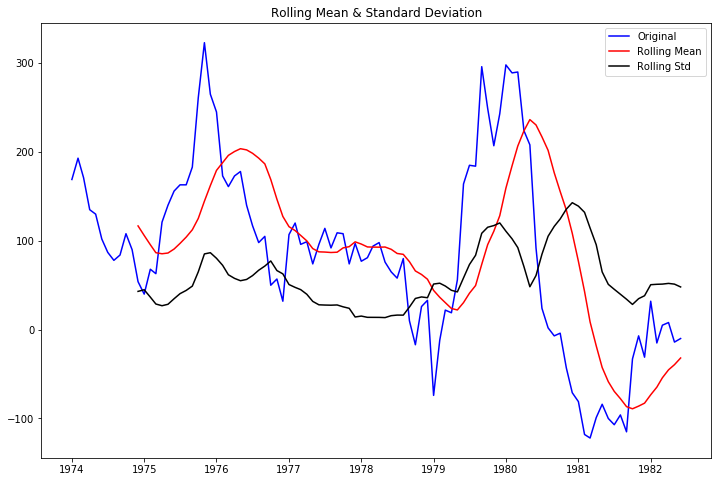

Results of Dickey-Fuller Test:
Test Statistic                 -2.469741
p-value                         0.123011
#Lags Used                      3.000000
Number of Observations Used    98.000000
Critical Value (1%)            -3.498910
Critical Value (5%)            -2.891516
Critical Value (10%)           -2.582760
dtype: float64


In [18]:
# Seasonal difference:
bus['seasonal_difference'] = bus.riders - bus.riders.shift(12)  
test_stationarity(bus.seasonal_difference.dropna(inplace=False))

<a id="perform-a-test-on-the-first-seasonal-differenced-timeseries"></a>
### Perform a Test on the First Seasonal-Differenced Time Series

At this point, we can see that we have a significant result!

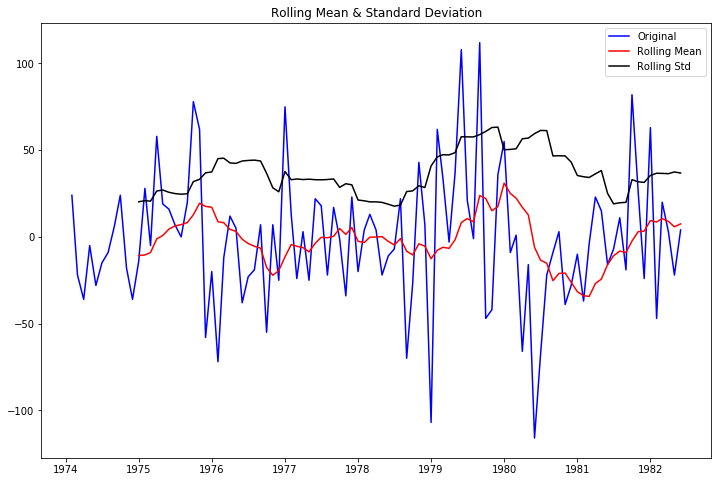

Results of Dickey-Fuller Test:
Test Statistic                -9.258520e+00
p-value                        1.427874e-15
#Lags Used                     0.000000e+00
Number of Observations Used    1.000000e+02
Critical Value (1%)           -3.497501e+00
Critical Value (5%)           -2.890906e+00
Critical Value (10%)          -2.582435e+00
dtype: float64


In [19]:
# First seasonal difference:
bus['seasonal_first_difference'] = bus.first_difference - bus.first_difference.shift(12)  
test_stationarity(bus.seasonal_first_difference.dropna(inplace=False))

#  
#  
<a id="load-the-european-retail-data"></a>
## Load the European Retail Data
---

Make the index the year and create an initial plot of the data.

In [20]:
df = pd.read_csv('../datasets/euretail.csv')
df.head()

,Year,Qtr1,Qtr2,Qtr3,Qtr4
0,1996,89.13,89.52,89.88,90.12
1,1997,89.19,89.78,90.03,90.38
2,1998,90.27,90.77,91.85,92.51
3,1999,92.21,92.52,93.62,94.15
4,2000,94.69,95.34,96.04,96.30


In [21]:
df = df.set_index(['Year'])
df.head()

,Qtr1,Qtr2,Qtr3,Qtr4
Year,,,,
1996,89.13,89.52,89.88,90.12
1997,89.19,89.78,90.03,90.38
1998,90.27,90.77,91.85,92.51
1999,92.21,92.52,93.62,94.15
2000,94.69,95.34,96.04,96.30


In [22]:
# !!! NEW FUNCTION !!!

df.stack().head()

Year      
1996  Qtr1    89.13
      Qtr2    89.52
      Qtr3    89.88
      Qtr4    90.12
1997  Qtr1    89.19
dtype: float64

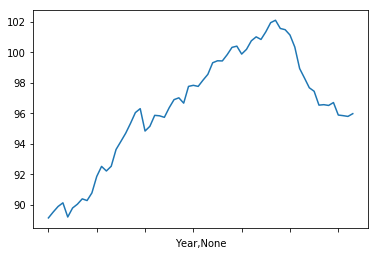

In [23]:
df.stack().plot()

<a id="create-autocorrelation-and-partial-autocorrelation-plots"></a>
## Create Autocorrelation and Partial Autocorrelation Plots 
---

Create a first-differenced time series of the retail data, then use `plot_acf` and `plot_pacf`.

In [24]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

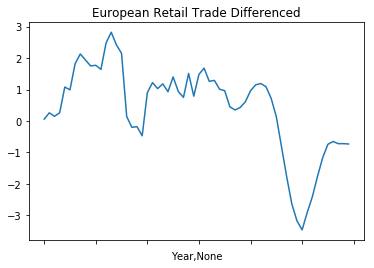

In [25]:
# Regular diff:
diff0 = df.stack().diff(periods=4)[4:]
diff0.plot(title='European Retail Trade Differenced')

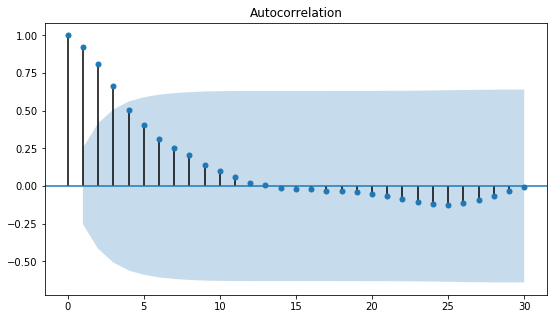

In [26]:
fig, ax = plt.subplots(figsize=(9,5))
plot_acf(diff0, lags=30, ax=ax)
plt.show()

/Users/edoardo/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


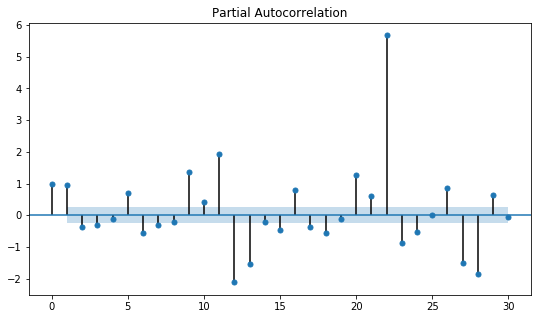

In [27]:
fig, ax = plt.subplots(figsize=(9,5))
plot_pacf(diff0, lags=30, ax=ax)
plt.show()

<a id="take-a-second-order-difference-of-the-retail-timeseries"></a>
### Take a Second-Order Difference of the Retail Time Series

Plot the ACF and PACF again with the second-order differenced series.

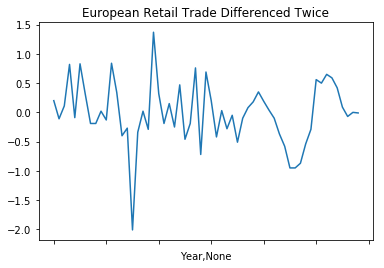

In [28]:
# Additional diff:
diff1 = diff0.diff()[1:]
diff1.plot(title='European Retail Trade Differenced Twice')


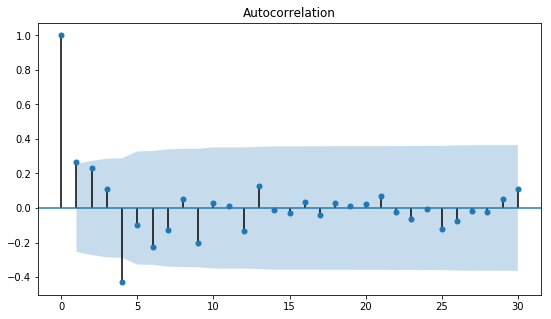

In [29]:
fig, ax = plt.subplots(figsize=(9,5))
plot_acf(diff1, lags=30, ax=ax)
plt.show()

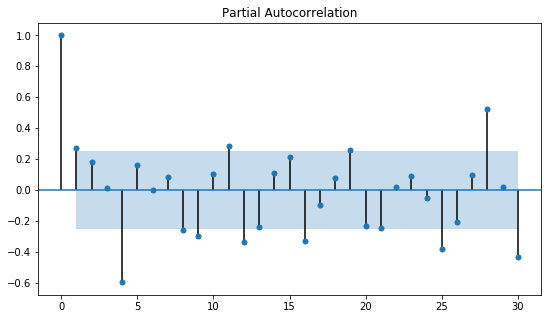

In [30]:
fig, ax = plt.subplots(figsize=(9,5))
plot_pacf(diff1, lags=30, ax=ax)
plt.show()

<a id="seasonal-arima-with-additional-predictors-sarimax"></a>
## Seasonal ARIMA With Additional Predictors (SARIMAX)
---

The [SARIMAX model](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html) is an advanced state-space model that allows us to build a seasonal ARIMA and also take into account the effects of other predictors.

The granular details of SARIMAX are beyond the scope of this walk-through, but we can build a model and use it to forecast as an example of Statsmodels' powerful time series analysis capabilities.

In [31]:
import statsmodels.api as sm
data = df.stack().values
model = sm.tsa.statespace.SARIMAX(data, 
                                  order=(0,1,1), 
                                  seasonal_order=(0,1,1,4))
results = model.fit()
print(results.summary())

                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                   64
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 4)   Log Likelihood                 -34.680
Date:                           Mon, 29 Oct 2018   AIC                             75.360
Time:                                   09:18:56   BIC                             81.593
Sample:                                        0   HQIC                            77.793
                                            - 64                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2901      0.155      1.868      0.062      -0.014       0.594
ma.S.L4       -0.6909      0.132     -5.240

/Users/edoardo/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


**Plot the residuals of the SARIMAX model.**

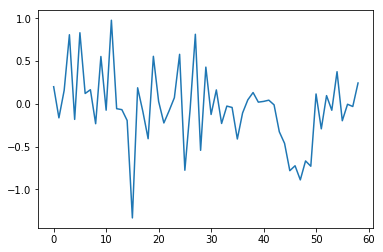

In [32]:
# Don't plot the first five values to account for data loss when differencing (d=1 + D=5).
residuals = results.resid[5:]
plt.plot(residuals)

**Plot the ACF and PACF of the residuals.**

What should we expect from the ACF and PACF of our residuals if the model is good?

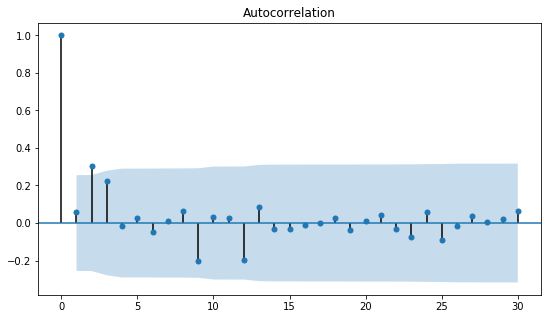

In [33]:
fig, ax = plt.subplots(figsize=(9,5))
plot_acf(residuals, lags=30, ax=ax)
plt.show()

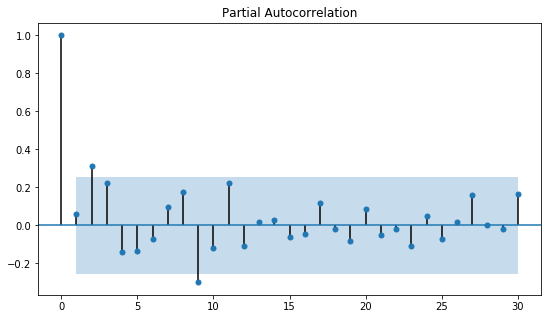

In [34]:
fig, ax = plt.subplots(figsize=(9,5))
plot_pacf(residuals, lags=30, ax=ax)
plt.show()

**Increase the order of the SARIMAX model.**

How do the results change?

In [35]:
model = sm.tsa.statespace.SARIMAX(data, 
                                  order=(0,1,2), 
                                  seasonal_order=(0,1,1,4))
results = model.fit()
results.summary()

/Users/edoardo/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   64
Model:             SARIMAX(0, 1, 2)x(0, 1, 1, 4)   Log Likelihood                 -32.809
Date:                           Mon, 29 Oct 2018   AIC                             73.618
Time:                                   09:19:07   BIC                             81.928
Sample:                                        0   HQIC                            76.862
                                            - 64                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2307      0.157      1.471      0.141      -0.077       0.538
ma.L2          0.2497      0.115      2.171      0.030       0.024       0.475
ma.S.L4       -0.6987      0.149     -4.695      0.000      -0.990      -0.407
sigma2         0.1694      0.028      5.944      0.000       0.114       0.225
===================================================================================
Ljung-Box (Q):                       33.80   Jarque-Bera (JB):                 1.55
Prob(Q):                              0.74   Prob(JB):                         0.46
Heteroskedasticity (H):               0.69   Skew:                            -0.10
Prob(H) (two-sided):                  0.41   Kurtosis:                         3.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
# AIC is slightly lower and therefore may be a better choice.

<a id="forecast-using-the-sarimax-model"></a>
### Forecast Using the SARIMAX Model

Statsmodels result objects from SARIMAX have a `.forecast()` function that can use the state-space model to predict out to future time points.

Forecast 12 additional time points and plot them.

/Users/edoardo/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


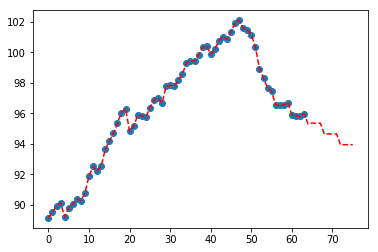

In [37]:
# Forecasting:
res = model.fit()
preds = res.forecast(12)
fcast = np.concatenate((data, preds), axis=0)

plt.figure();
plt.plot(data, 'o' , fcast, 'r--');

<a id='additional-resources'></a>
## Additional Resources
---

+ A Soft Introduction to [Akaike Information Criteria](https://coolstatsblog.com/2013/08/14/using-aic-to-test-arima-models-2/)
+ A [Video Introduction](https://www.youtube.com/watch?v=YkD7ydzp9_E) to AIC
+ [Wikipedia's Entry on AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion)
+ A Seasonal ARIMA [Code-Along](http://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html) From Statsmodels
+ An excellent [Blog Code-Along](http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/) to Seasonal ARIMA + [iPython Notebook](https://github.com/seanabu/seanabu.github.io/blob/master/Seasonal_ARIMA_model_Portland_transit.ipynb)
+ Duke's Breakdown of [ACF and PACF](http://people.duke.edu/~rnau/411arim3.htm)
+ Duke's Breakdown of Available [Stationarity Transformations](http://people.duke.edu/~rnau/whatuse.htm)
+ A 35-Minute [Video Econometric](https://www.youtube.com/watch?v=Y2khrpVo6qI) Breakdown of ARIMA
+ [Wikipedia's Entry on Dickey-Fuller](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test)
+ Stats Exchange's Breakdown of [Augmented Dickey-Fuller](http://stats.stackexchange.com/questions/44647/which-dickey-fuller-test-should-i-apply-to-a-time-series-with-an-underlying-mode)
+ Compliments of Jonathan: A Walk Through of Selecting PDQ from [Duke](http://people.duke.edu/~rnau/411arim.htm)
+ Compliments of Jonathan, Pt. 2: A Big Data Analytics With ARIMA [Case Study](http://sda-pakdd2014.weebly.com/uploads/2/4/0/8/24088081/7w12.pdf)
+ Bonus: Check Out [Granger Causality Tests](https://en.wikipedia.org/wiki/Granger_causality)
